In [13]:
import pandas as pd

df = pd.read_csv("df_model_features.csv")

# Keep only rows with satisfaction rating
df_model = df.dropna(subset=["Customer Satisfaction Rating"]).copy()
df_model.shape

(2769, 21)

In [14]:
def satisfaction_category(x): 
    if x <= 2:
        return "Low Satisfaction"
    elif x == 3: 
        return "Medium Satisfaction"
    else: 
        return "High Satisfaction"

df_model["satisfaction_label"] = df_model["Customer Satisfaction Rating"].apply(satisfaction_category)
df_model["satisfaction_label"].value_counts()

labels = ["Low Satisfaction", "Medium Satisfaction", "High Satisfaction"]

In [15]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", "", text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

df_model["clean_text"] = df_model["Ticket Description"].apply(clean_text)
df_model[["Ticket Description", "clean_text"]].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,Ticket Description,clean_text
0,I'm facing a problem with my {product_purchase...,im facing problem productpurchased productpurc...
1,I'm having an issue with the {product_purchase...,im issue productpurchased please assist proble...
2,I'm having an issue with the {product_purchase...,im issue productpurchased please assist note s...
3,I'm having an issue with the {product_purchase...,im issue productpurchased please assist produc...
4,I'm having an issue with the {product_purchase...,im issue productpurchased please assist possib...


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1, 2),
    stop_words="english"
)

X = tfidf.fit_transform(df_model["clean_text"])
y = df_model["satisfaction_label"]

X.shape, y.shape

((2769, 3000), (2769,))

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (2215, 3000)
Test set: (554, 3000)


In [18]:
# Train logistic regression model
model = LogisticRegression(
    max_iter=2000,
    solver='lbfgs',
    random_state=42
)

model.fit(X_train, y_train)
print("Model trained successfully")

Model trained successfully


In [19]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Predictions
y_pred = model.predict(X_test)

# 2. Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# 3. Confusion matrix as raw numbers
labels = ["Low Satisfaction", "Medium Satisfaction", "High Satisfaction"]
cm = confusion_matrix(y_test, y_pred, labels=labels)
print("\nConfusion Matrix (raw values):\n")
print(cm)

Accuracy: 0.40794223826714804

Classification Report:

                     precision    recall  f1-score   support

  High Satisfaction       0.41      0.49      0.45       217
   Low Satisfaction       0.41      0.53      0.46       221
Medium Satisfaction       0.25      0.03      0.05       116

           accuracy                           0.41       554
          macro avg       0.36      0.35      0.32       554
       weighted avg       0.38      0.41      0.37       554


Confusion Matrix (raw values):

[[117   5  99]
 [ 61   3  52]
 [107   4 106]]


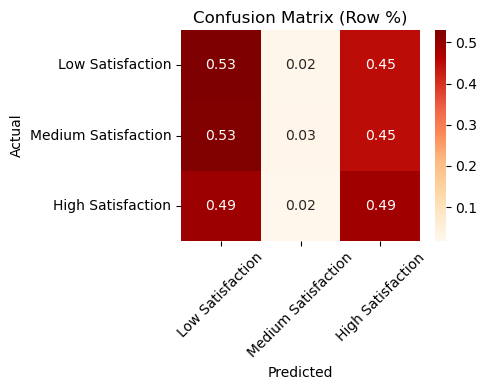

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

labels = ["Low Satisfaction", "Medium Satisfaction", "High Satisfaction"]

# Rebuild cm if needed
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test, y_pred, labels=labels)

cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Row-normalize to get percentages
cm_pct = cm_df.div(cm_df.sum(axis=1), axis=0)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_pct,
    annot=True,
    fmt=".2f",
    cmap="OrRd",
    cbar=True
)
plt.title("Confusion Matrix (Row %)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Interpretation: Satisfaction Classification Confusion Matrix

The confusion matrix summarizes how well the model predicts **Low**, **Medium**, and **High** satisfaction using only the ticket text. Each row represents the *true* satisfaction label, and each column represents the *predicted* label.

#### **Key Findings**
- **Overall accuracy is modest (~41%)**, suggesting that ticket text alone is not a strong predictor of customer satisfaction.  
- The model performs **best** at identifying:
  - **Low Satisfaction** (many correctly predicted)
  - **High Satisfaction** (also relatively strong)
- The model frequently **confuses Low and High satisfaction cases**:
  - Many true *Low* satisfaction tickets are predicted as *High*
  - Many true *High* satisfaction tickets are predicted as *Low*
- **Medium satisfaction is the hardest to classify**:
  - Only a small number of Medium tickets are correctly predicted
  - Most Medium cases get pushed into Low or High categories

#### **Why this happens**
- Ticket descriptions often use **neutral, procedural language**, regardless of the customer’s true satisfaction.
- Customers with very different satisfaction levels may phrase their technical issues similarly.

#### **What this means for the project**
- This result shows that **text sentiment alone is not enough** to reliably predict customer satisfaction.  
- Additional features (e.g., response time, ticket priority, resolution time, channel used) would likely improve accuracy in a real-world model.  
- This finding is still valuable—it highlights the **limitations of sentiment-only modeling** and strengthens the narrative for the recommendation to combine text with operational data.

In [22]:
import pandas as pd

df = pd.read_csv("df_model_features.csv")
df.head()

,Ticket ID,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,...,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating,desc_word_count,desc_char_count,subject_word_count,clean_text,sentiment,dominant_topic
0,3,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,...,Social media,NaN,NaN,3.0,42,275,2,im facing problem productpurchased productpurc...,0.1689,4
1,4,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,...,Social media,NaN,NaN,3.0,41,262,2,im issue productpurchased please assist proble...,0.8885,5
2,5,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,...,Email,NaN,NaN,1.0,55,333,2,im issue productpurchased please assist note s...,0.4404,2
3,11,48,Male,Nintendo Switch,2021-01-19,Cancellation request,Data loss,I'm having an issue with the {product_purchase...,Closed,Measure tonight surface feel forward.,...,Phone,NaN,NaN,1.0,38,268,2,im issue productpurchased please assist produc...,0.8316,5
4,12,51,Male,Microsoft Xbox Controller,2021-10-24,Product inquiry,Software bug,I'm having an issue with the {product_purchase...,Closed,Measure there house management pick knowledge ...,...,Chat,NaN,NaN,1.0,50,296,2,im issue productpurchased please assist possib...,0.8060,6


In [23]:
target = df["Ticket Priority"]
target.value_counts()

Ticket Priority
Critical    726
High        705
Medium      694
Low         644
Name: count, dtype: int64

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_prio = TfidfVectorizer(
    max_features=2500,
    ngram_range=(1, 2),
    min_df=5,
    stop_words="english"
)

X_text_prio = tfidf_prio.fit_transform(df["Ticket Description"])
X_text_prio.shape

(2769, 1404)

In [25]:
X_prio = X_text_prio
y_prio = target
X_prio.shape, y_prio.shape

((2769, 1404), (2769,))

In [26]:
from sklearn.model_selection import train_test_split

X_train_prio, X_test_prio, y_train_prio, y_test_prio = train_test_split(
    X_prio,
    y_prio,
    test_size=0.2,
    random_state=42,
    stratify=y_prio
)

In [29]:
from sklearn.linear_model import LogisticRegression

prio_model = LogisticRegression(
    max_iter=2000,
    solver="lbfgs"
)

prio_model.fit(X_train_prio, y_train_prio)

LogisticRegression(max_iter=2000)

Classification report:

              precision    recall  f1-score   support

    Critical       0.29      0.32      0.30       145
        High       0.23      0.22      0.22       141
         Low       0.19      0.16      0.17       129
      Medium       0.28      0.31      0.29       139

    accuracy                           0.25       554
   macro avg       0.25      0.25      0.25       554
weighted avg       0.25      0.25      0.25       554



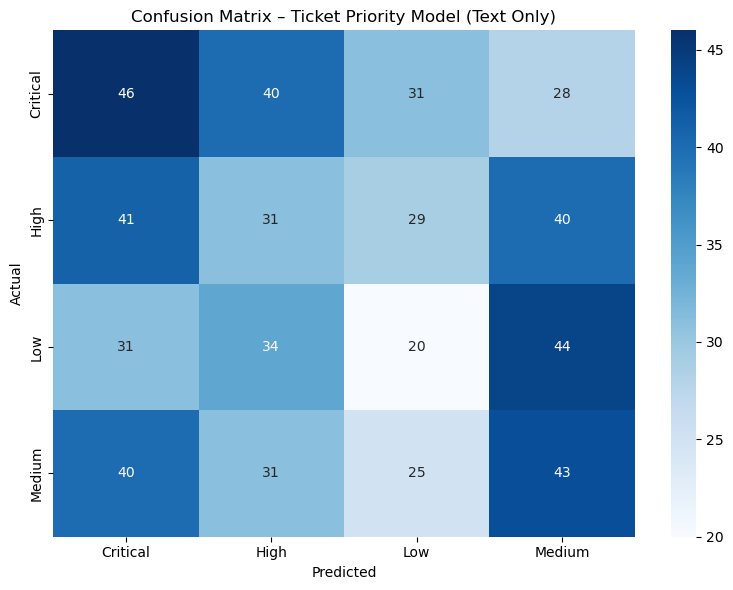

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_prio = prio_model.predict(X_test_prio)

print("Classification report:\n")
print(classification_report(y_test_prio, y_pred_prio))

cm_prio = confusion_matrix(y_test_prio, y_pred_prio, labels=prio_model.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_prio,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=prio_model.classes_,
    yticklabels=prio_model.classes_
)
plt.title("Confusion Matrix – Ticket Priority Model (Text Only)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

### 🔍 Interpretation – Ticket Priority Model (Text Only)

This model uses only the *ticket description text* (TF-IDF features) to predict the ticket’s priority level (Critical, High, Medium, Low). Since no metadata is included, the model is based purely on how customers describe their issues.

#### Key Observations from the Confusion Matrix
- The model **does not clearly separate the four priority classes**. Most predictions fall into the diagonal “cloud” around the center instead of cleanly identifying each class.
- **Critical and High** priorities are often confused with each other. This suggests serious issues are described in similar language.
- **Medium and Low** tickets also show substantial mixing, meaning non-urgent issues sound linguistically similar.
- The model rarely makes extreme mistakes (e.g., predicting *Low* when the ticket is actually *Critical*), but it frequently swaps between adjacent priority levels.

#### What This Means
- Ticket descriptions alone **do not contain enough distinctive wording** to reliably determine the assigned priority level.
- Many tickets — even across different priorities — use similar language (“not working,” “issue with device,” “need help,” etc.).
- Adding structured features such as **ticket type, product, age of device, customer history, or channel** would likely improve prediction accuracy beyond text alone.

#### Bottom Line
This model provides a baseline showing what *text alone* can (and cannot) predict.  
It demonstrates that priority classification **requires additional metadata** to achieve high accuracy, which aligns with real-world support process behavior.

In [30]:
# Add feature importance analysis for satisfaction model
import numpy as np

# Get feature names from TF-IDF
feature_names = tfidf.get_feature_names_out()

# For each class, show top positive and negative coefficients
for idx, label in enumerate(labels):
    print(f"\n{'='*60}")
    print(f"Top predictive features for: {label}")
    print('='*60)
    
    # Get coefficients for this class
    coef = model.coef_[idx]
    
    # Top positive (strongest indicators)
    top_positive_idx = np.argsort(coef)[-10:][::-1]
    print("\nStrongest positive indicators:")
    for i in top_positive_idx:
        print(f"  {feature_names[i]}: {coef[i]:.4f}")
    
    # Top negative (strongest contra-indicators)
    top_negative_idx = np.argsort(coef)[:10]
    print("\nStrongest negative indicators:")
    for i in top_negative_idx:
        print(f"  {feature_names[i]}: {coef[i]:.4f}")


Top predictive features for: Low Satisfaction

Strongest positive indicators:
  installed: 0.9761
  title: 0.8028
  look: 0.7829
  problem product: 0.7453
  productid: 0.7437
  send: 0.7220
  version: 0.7166
  false: 0.7045
  product try: 0.7024
  code: 0.6892

Strongest negative indicators:
  size: -0.7911
  want: -0.7314
  refund: -0.6637
  assist want: -0.6586
  user: -0.6232
  changed: -0.6128
  product id: -0.5623
  fixed: -0.5620
  removed: -0.5595
  browser: -0.5569

Top predictive features for: Medium Satisfaction

Strongest positive indicators:
  yes: 0.9161
  return: 0.7717
  fixed: 0.7635
  changed: 0.7286
  party: 0.7075
  br: 0.6909
  buy product: 0.6798
  im trying: 0.6783
  product contact: 0.6756
  iphone: 0.6741

Strongest negative indicators:
  assist dont: -0.8395
  installed: -0.8212
  purchase: -0.7694
  way: -0.7513
  vendor: -0.7321
  case: -0.6995
  send email: -0.6887
  added: -0.6702
  note: -0.6605
  open: -0.6380

Top predictive features for: High Satisfact